# Fraud Detection
MSCA 31015 Data Science for Consulting

## I. EDA & Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from google.colab import drive 
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [2]:
train = pd.read_csv('/content/gdrive/MyDrive/train.csv', index_col=0, parse_dates=['trans_date_trans_time', 'dob'])
test = pd.read_csv('/content/gdrive/MyDrive/test.csv', index_col=0, parse_dates=['trans_date_trans_time', 'dob'])
df = pd.concat([train, test])
df.shape

(1852394, 22)

In [3]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              

### i. numeric variables

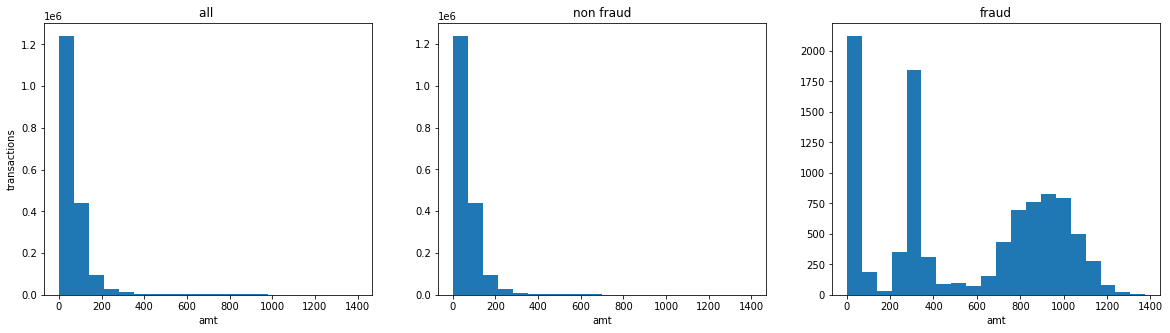

In [5]:
# amt
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_ylabel('transactions')

ax[0].set_xlabel('amt')
ax[1].set_xlabel('amt')
ax[2].set_xlabel('amt')

ax[0].set_title('all ')
ax[1].set_title('non fraud')
ax[2].set_title('fraud')

ax[0].hist(df.loc[df['amt']<=1400, 'amt'], bins=20)
ax[1].hist(df.loc[(df['amt']<=1400) & (df['is_fraud']==0), 'amt'], bins=20)
ax[2].hist(df.loc[(df['amt']<=1400) & (df['is_fraud']==1), 'amt'], bins=20);

### ii. datetime variables

In [6]:
# trans_date_trans_time
df['trans_date'] = df['trans_date_trans_time'].dt.date
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_ym'] = df['trans_date_trans_time'].dt.to_period('M')

In [7]:
df['agg'] = 1
df['index'] = df['trans_date_trans_time']
df = df.set_index('index').sort_index()

# rolling: 60 day transaction amount average by card number
df_amt_60d = df.groupby('cc_num')['amt'].rolling('60D').mean().shift().reset_index().fillna(0)
df_amt_60d.columns = ['cc_num','trans_date','avg_amt_60d']
df_amt_60d['trans_date'] = df_amt_60d['trans_date'].dt.date
df_amt_60d = df_amt_60d.groupby(['cc_num','trans_date'])['avg_amt_60d'].min().reset_index()

# rolling: 60 day transactions by card number
df_60d = df.groupby('cc_num')['agg'].rolling('60D').count().shift().reset_index().fillna(0)
df_60d.columns = ['cc_num','trans_date','60d']
df_60d['trans_date'] = df_60d['trans_date'].dt.date
df_60d = df_60d.groupby(['cc_num','trans_date'])['60d'].min().reset_index()

# merge by cc_num, trans_date
df = df.merge(df_amt_60d, left_on = ['cc_num','trans_date'], right_on = ['cc_num','trans_date'], how = 'left')\
    .merge(df_60d, left_on = ['cc_num','trans_date'], right_on = ['cc_num','trans_date'], how = 'left')
df[['avg_amt_60d','60d']]= df[['avg_amt_60d','60d']].fillna(0)

In [8]:
# age = trans_date_trans_time - dob
df['age'] = np.round((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1,'Y'))

### iii. categorical variables

In [9]:
# gender
(pd.crosstab(df['gender'], df['is_fraud'])/len(df)).sort_values(by=1)

is_fraud,0,1
gender,,
M,0.449631,0.002565
F,0.545159,0.002645


In [10]:
# category
(pd.crosstab(df['category'], df['is_fraud'])/len(df)).sort_values(by=1)

is_fraud,0,1
category,,
travel,0.031203,0.000084
grocery_net,0.034929,0.000094
health_fitness,0.066059,0.000100
food_dining,0.070462,0.000111
home,0.094578,0.000143
personal_care,0.070069,0.000157
entertainment,0.072245,0.000158
kids_pets,0.087143,0.000164
misc_pos,0.061492,0.000174


In [11]:
# one hot encoding
df = pd.concat([df, pd.get_dummies(df[['gender', 'category']], drop_first=True)], axis=1)

### iv. interactive visualizations

In [2]:
# amt by city, age, gender
from ipywidgets import interact
import plotly.graph_objects as go

fig = go.FigureWidget()
scatt = fig.add_histogram()

@interact(state=df['state'].unique(), gender=df['gender'].unique(), age=(14,100,5), is_fraud=[0,1])

def update(state='NC',gender='M', age=14, is_fraud=1):
    with fig.batch_update():
        scatt=df[(df['state'] == state) & (df['gender'] == gender) & (df['age'] >= age) & (df['is_fraud'] == is_fraud)]['amt']
        fig.data[0].x=scatt

fig.update_layout(xaxis_title="Transactions", yaxis_title="Transaction Amount")
fig.show()

NameError: name 'df' is not defined

In [13]:
fig = go.Figure()
fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=df[df['is_fraud'] == 1]['long'],
        lat=df[df['is_fraud'] == 1]['lat'],
        marker=dict(color=df[df['is_fraud'] == 1]['is_fraud'], line_color='rgb(40,40,40)', line_width=0.5, sizemode='area'),
        name='test'))
fig.update_layout(geo=dict(landcolor='rgb(217,217,217)',), mapbox_style="open-street-map")

In [14]:
import plotly.express as px 
fig = px.scatter_mapbox(df[df['is_fraud'] == 1], lat="lat", lon="long", hover_name="city",
                        zoom=3, height=500, color="is_fraud",  color_discrete_sequence=px.colors.cyclical.IceFire)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## II. Modeling

### i. correlation

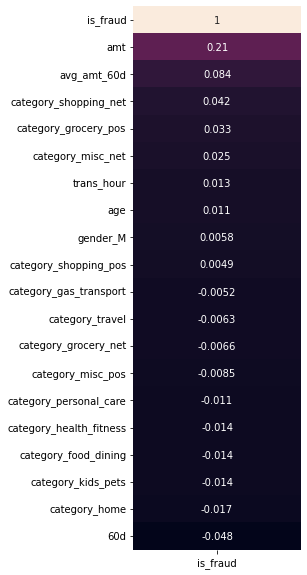

In [15]:
cols = ['amt', 'trans_hour', 'avg_amt_60d', '60d', 'age', 'gender_M', 
        'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 
        'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 
        'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel']
import seaborn as sn
plt.figure(figsize=(3,10))
sn.heatmap(df[cols+['is_fraud']].corr()[['is_fraud']].sort_values(by='is_fraud', ascending=False), annot=True, cbar=False);

### ii. oversampling

In [16]:
df['is_fraud'].value_counts(normalize=True)

0    0.99479
1    0.00521
Name: is_fraud, dtype: float64

In [17]:
fraud_oversample = df[df['is_fraud'] == 1].sample(df[df['is_fraud'] == 0]['amt'].count(), replace=True)
df_oversampled = pd.concat([df[df['is_fraud'] == 0], fraud_oversample], axis=0)

###  iii. train test split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_oversampled[cols], df_oversampled['is_fraud'], train_size=2/3)

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def model_results(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('train:')
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print('test:')
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    return model

### iv. logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression
model_results(LogisticRegression())

train:
[[1101212  127328]
 [ 261951  966499]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85   1228540
           1       0.88      0.79      0.83   1228450

    accuracy                           0.84   2456990
   macro avg       0.85      0.84      0.84   2456990
weighted avg       0.85      0.84      0.84   2456990

test:
[[550133  64070]
 [131171 483122]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85    614203
           1       0.88      0.79      0.83    614293

    accuracy                           0.84   1228496
   macro avg       0.85      0.84      0.84   1228496
weighted avg       0.85      0.84      0.84   1228496



LogisticRegression()

### v. decision tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt = model_results(DecisionTreeClassifier(max_depth=3))

train:
[[1144632   83908]
 [ 201827 1026623]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89   1228540
           1       0.92      0.84      0.88   1228450

    accuracy                           0.88   2456990
   macro avg       0.89      0.88      0.88   2456990
weighted avg       0.89      0.88      0.88   2456990

test:
[[572426  41777]
 [101071 513222]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89    614203
           1       0.92      0.84      0.88    614293

    accuracy                           0.88   1228496
   macro avg       0.89      0.88      0.88   1228496
weighted avg       0.89      0.88      0.88   1228496



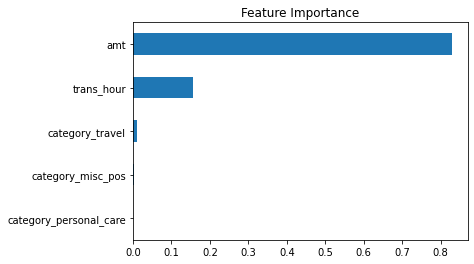

In [22]:
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values().tail().plot(kind='barh', title='Feature Importance');

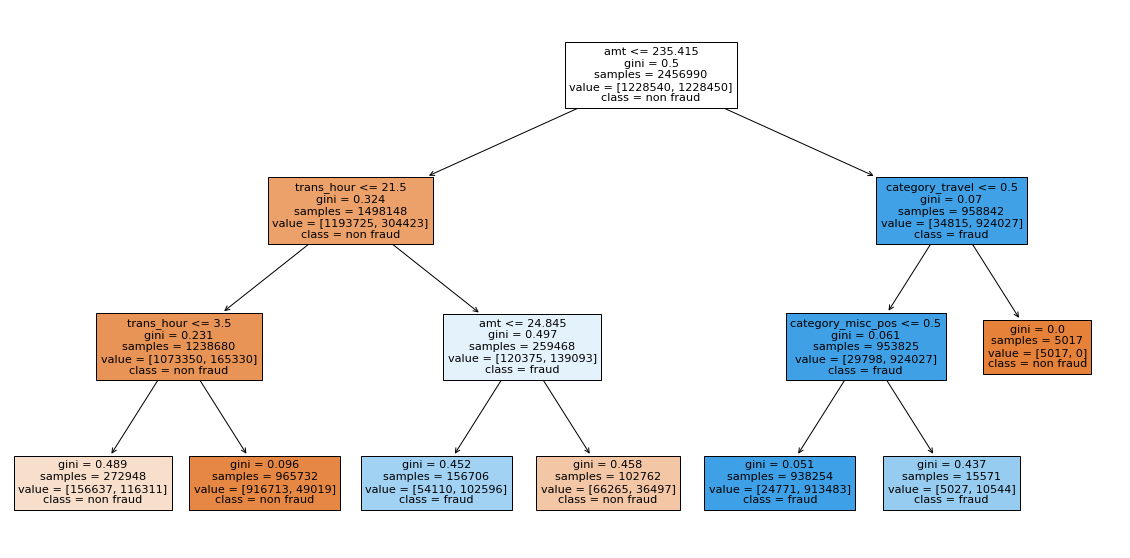

In [23]:
plt.figure(figsize=(20, 10))
from sklearn import tree
tree.plot_tree(dt, max_depth=3, feature_names=cols, class_names=['non fraud', 'fraud'], filled=True);

### vi. random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
model_results(RandomForestClassifier(n_estimators=10, max_depth=3))

train:
[[1133679   94861]
 [ 184002 1044448]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89   1228540
           1       0.92      0.85      0.88   1228450

    accuracy                           0.89   2456990
   macro avg       0.89      0.89      0.89   2456990
weighted avg       0.89      0.89      0.89   2456990

test:
[[567213  46990]
 [ 92577 521716]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89    614203
           1       0.92      0.85      0.88    614293

    accuracy                           0.89   1228496
   macro avg       0.89      0.89      0.89   1228496
weighted avg       0.89      0.89      0.89   1228496



RandomForestClassifier(max_depth=3, n_estimators=10)

### vii. xgboost

In [25]:
from xgboost import XGBClassifier
model_results(XGBClassifier(n_estimators=10, max_depth=3))

train:
[[1171410   57130]
 [ 109978 1118472]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93   1228540
           1       0.95      0.91      0.93   1228450

    accuracy                           0.93   2456990
   macro avg       0.93      0.93      0.93   2456990
weighted avg       0.93      0.93      0.93   2456990

test:
[[585914  28289]
 [ 54852 559441]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    614203
           1       0.95      0.91      0.93    614293

    accuracy                           0.93   1228496
   macro avg       0.93      0.93      0.93   1228496
weighted avg       0.93      0.93      0.93   1228496



XGBClassifier(n_estimators=10)